## CSV to parquet 

#### idea:
1. convert from csv to parquet
   - keep the description -> how? -> look for 
   - delete csv afterwards
2. adapt ASCII optimized code for parquet reading

#### remarks/differences to ASCII code:
- Column names are different

In [9]:
import pyarrow.parquet as pq
import pyarrow as pa
import pyarrow.compute as pc
import time
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pandas as pd 
from itertools import zip_longest


### code for compatibility across all datatypes:

In [10]:
def histograms_txt_csv(file, num_bins=135, chunksize = 10_000_000, tot_range = (1.7,3.2), toa_range = (0, 250)):
    # plt style
    plt.style.use('ggplot')
    plt.rcParams['text.usetex']=False

    print('Accumulating histograms in chunks...')
    
    # ToT bin edges 
    bin_edges_tot = np.linspace(tot_range[0], tot_range[1], num_bins + 1)
    hist_sig_tot = np.zeros(num_bins, dtype=int)
    hist_bkgrnd_tot = np.zeros(num_bins, dtype=int)

    # deltaT bin edges 
    bin_edges_toa = np.linspace(delta_range[0], delta_range[1], num_bins + 1)
    hist_sig_toa= np.zeros(num_bins, dtype=int)
    hist_bkgrnd_toa = np.zeros(num_bins, dtype=int)

    
def histograms_parquet(file, num_bins=135, chunksize = 10_000_000, tot_range = (1.7,3.2), toa_range = (0, 250)):
    # plt style
    plt.style.use('ggplot')
    plt.rcParams['text.usetex']=False

    print('Accumulating histograms in chunks...')
    
    # ToT bin edges 
    bin_edges_tot = np.linspace(tot_range[0], tot_range[1], num_bins + 1)
    hist_sig_tot = np.zeros(num_bins, dtype=int)
    hist_bkgrnd_tot = np.zeros(num_bins, dtype=int)

    # deltaT bin edges 
    bin_edges_toa = np.linspace(delta_range[0], delta_range[1], num_bins + 1)
    hist_sig_toa= np.zeros(num_bins, dtype=int)
    hist_bkgrnd_toa = np.zeros(num_bins, dtype=int)



def compatible_histograms(file):
    
    colummn_names = ['Tstamp_us', 'Trg_Id', 'Entries', 'Brd', 'Ch', 'ToA_ns', 'ToT_ns', 'Edge']
    
    # check file type and separate standard from .parquet
    if os.path.isfile(file):
        ext = os.path.splitext(file)[1].lower()
        if ext in {'.parquet', '.csv', '.txt'}:
            print(f'Correct file type {ext} has been put in...')
    
            
            if ext in {'.csv', '.txt'}:
                df = pd.read_csv(file, skipinitialspace=True, comment='/', nrows=1000)
                print(f'The column names of this file type are: {list(df.columns)}...')
                ### maybe add here something that checks if the column names are the same in all dataframes -> in ASCII the columns are different
                    
            if ext == '.parquet':
                df = pd.read_parquet(file, skipinitialspace=True, )
    
        else:
            print(f'The file type is incorrect. File type is: {ext}')
       
    

### Coincidence Code
Idea:
- write several functions to intertwine $\Rightarrow$ this should make the code more modular and easier to adapt
- modify parquet_histograms.py 
- implement walk-time correction

In [ ]:
def accumulate_histograms(path_sig, path_bkg, batch_size=5_000_000, tot_range=(1, 5), delta_range=(0, 100), num_bins=135, columns=("ToT_ns","ToA_ns")):
    clock_start = time.perf_counter()  # start timer 

    print('Starting to accumulate histograms in batches...')

    pf_sig = pq.ParquetFile(path_sig)    # Parquet reader 
    pf_bkg = pq.ParquetFile(path_bkg) # Parquet reader 

    it_sig = pf_sig.iter_batches(batch_size=batch_size, columns=list(columns))   # stream batches 
    it_bkg = pf_bkg.iter_batches(batch_size=batch_size, columns=list(columns))   # stream batches

    # bins and widths once
    bin_edges_tot   = np.linspace(tot_range[0], tot_range[1], num_bins + 1)     # shared ToT bins 
    bin_edges_delta = np.linspace(delta_range[0], delta_range[1], num_bins + 1) # shared delta bins 

    # accumulators
    hist_sig_tot = np.zeros(num_bins, dtype=int)      # set histogram bins to accumulate 
    hist_bkg_tot = np.zeros(num_bins, dtype=int)       
    hist_sig_delta = np.zeros(num_bins, dtype=int)     
    hist_bkg_delta = np.zeros(num_bins, dtype=int) 

    for i, (b1, b2) in enumerate(zip_longest(it_sig, it_bkg, fillvalue=None), start=1):
        print(f"Processing pair {i}...",
              f"file1={'present' if b1 is not None else 'None'}",
              f"file2={'present' if b2 is not None else 'None'}")  # progress 

        ### implement filter stage below (maybe with function data_filter())
        ### also implement walk correction below ()
        if b1 is not None:
            df_sig = b1.to_pandas()  # pandas chunk 
            if "ToT_ns" in df_sig:
                h, _ = np.histogram(df_sig["ToT_ns"].dropna(), bins=bin_edges_tot)  # ToT
                hist_sig_tot += h  # accumulate 
            if "ToA_ns" in df_sig:
                h, _ = np.histogram(df_sig["ToA_ns"].dropna(), bins=bin_edges_delta) # delta 
                hist_sig_delta += h  # accumulate

        if b2 is not None:
            df_bkg = b2.to_pandas()  # pandas chunk 
            if "ToT_ns" in df_bkg:
                h, _ = np.histogram(df_bkg["ToT_ns"].dropna(), bins=bin_edges_tot)  # ToT 
                hist_bkg_tot += h  # accumulate 
            if "ToA_ns" in df_bkg:
                h, _ = np.histogram(df_bkg["ToA_ns"].dropna(), bins=bin_edges_delta) # delta 
                hist_bkg_delta += h  # accumulate

In [ ]:
    # normalize to densities (delta only)
    n_sig_delta   = hist_sig_delta.sum()                      # total samples 
    n_bkg_delta   = hist_bkg_delta.sum()                  # total samples 
    dens_sig      = (hist_sig_delta / (n_sig_delta * w_delta)) if n_sig_delta > 0 else np.zeros_like(hist_sig_delta, float)  # density 
    dens_bkg      = (hist_bkg_delta / (n_bkg_delta * w_delta)) if n_bkg_delta > 0 else np.zeros_like(hist_bkggrnd_delta, float)  # density 
    resid_delta   = dens_sig - dens_bkg                       # residual density 
    centers_delta = 0.5 * (bin_edges_delta[:-1] + bin_edges_delta[1:])           # centers 
    centers_tot   = 0.5 * (bin_edges_tot[:-1] + bin_edges_tot[1:])               # centers 

    w_tot   = np.diff(bin_edges_tot)     # ToT bin widths
    w_delta = np.diff(bin_edges_delta)   # delta bin widths 

In [34]:
def subtract_hists_and_plot():
    '''takes only the accumulated Histogram data for 
    '''
    
    plt.style.use('ggplot')  # style 
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))  # grid

    axs[0,0].bar(bin_edges_tot[:-1], hist_sig_tot, width=w_tot, align="edge", alpha=0.7, color="blue")  # ToT signal 
    axs[0,0].set_title("Signal ToT counts"); axs[0,0].set_xlabel("ToT ns"); axs[0,0].set_ylabel("Count")  # labels 
    axs[0,1].bar(bin_edges_tot[:-1], hist_bkg_tot, width=w_tot, align="edge", alpha=0.7, color="red")    # ToT background
    axs[0,1].set_title("Background ToT counts"); axs[0,1].set_xlabel("ToT ns")  # labels

    axs[1,0].bar(bin_edges_delta[:-1], hist_sig_delta, width=w_delta, align='edge', alpha=0.7, color='blue')  # delta signal 
    axs[1,0].set_title("Signal ToA counts"); axs[1,0].set_xlabel("ToA ns"); axs[1,0].set_ylabel("Count")  # labels 
    axs[1,1].bar(bin_edges_delta[:-1], hist_bkggrnd_delta, width=w_delta, align='edge', alpha=0.7, color='red')  # delta background 
    axs[1,1].set_title("Background ToA counts"); axs[1,1].set_xlabel("ToA ns")  # labels

    axs[2,0].bar(centers_delta, resid_delta, width=w_delta, align="center", alpha=0.8, color="purple")  # residual 
    axs[2,0].axhline(0, color='k', lw=1); axs[2,0].set_title("Delta residual (density)")  # baseline/title 
    axs[2,0].set_xlabel("ToA ns"); axs[2,0].set_ylabel("Density diff")  # labels 

    # Make axs[2,1] empty
    axs[2,1].axis('off')  # hide the last subplot 
    # Alternatively: fig.delaxes(axs[2,1])  # remove axis entirely 

    plt.tight_layout(); plt.show()  # layout and display 

    clock_time = time.perf_counter() - clock_start  # end timer
    print(f'Histograms have been successfully created in {clock_time:.2f}s')  # report 

In [35]:
def main():
    (centers_tot, bin_edges_tot, centers_delta, bin_edges_delta,
            hist_sig_tot, hist_bkg_tot,
            hist_sig_delta, hist_bkg_delta, resid_delta) = accumulate_histograms('data/test_signal_Run699_list.parquet', 'data/test_background_Run702_list.parquet')
    plot_hist(centers_tot, bin_edges_tot, centers_delta, bin_edges_delta,
            hist_sig_tot, hist_bkg_tot,
            hist_sig_delta, hist_bkg_delta, resid_delta)

Starting to accumulate histograms in batches...
Processing pair 1... file1=present file2=present
Processing pair 2... file1=present file2=present


NameError: name 'w_tot' is not defined

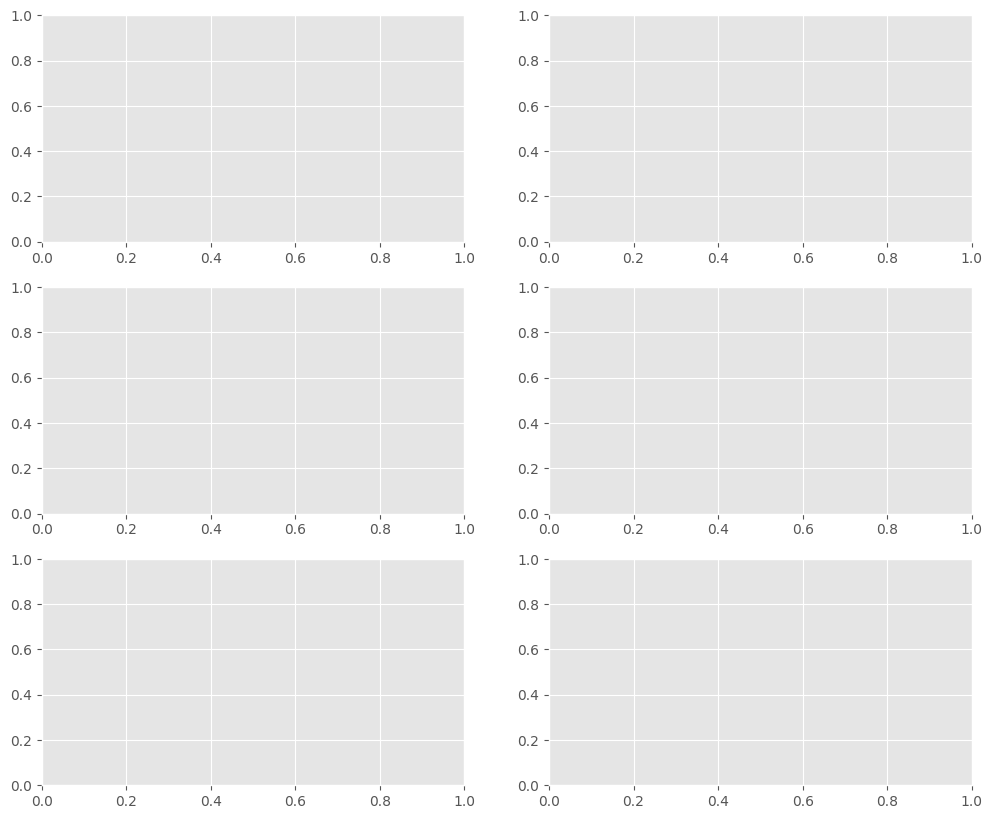

In [36]:
main()    